In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd

# Load Data

In [3]:
from enfobench.dataset import DemandDataset

ds = DemandDataset("data")

In [4]:
unique_ids = ds.metadata_subset.list_unique_ids()

In [5]:
len(unique_ids)

100

In [6]:
unique_id = unique_ids[0]
unique_id

'70aec446c47486f3'

In [7]:
target, past_covariates, metadata = ds.get_data_by_unique_id(unique_id)

In [8]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24320 entries, 2012-10-09 08:30:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       24317 non-null  float64
dtypes: float64(1)
memory usage: 380.0 KB


In [9]:
past_covariates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19862 entries, 2011-11-23 11:00:00 to 2014-02-28 00:00:00
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      19862 non-null  float32
 1   dew_point        19862 non-null  float32
 2   pressure         19862 non-null  float32
 3   wind_speed       19862 non-null  float32
 4   wind_gust        19862 non-null  float32
 5   wind_bearing     19862 non-null  float32
 6   precipitation    19862 non-null  float32
 7   snow             19862 non-null  float32
 8   cloud_cover      19862 non-null  float32
 9   solar_radiation  19862 non-null  float32
dtypes: float32(10)
memory usage: 931.0 KB


# Make external forecasts based on covariates

In [10]:
from enfobench.dataset.utils import create_perfect_forecasts_from_covariates

perfect_forecasts = create_perfect_forecasts_from_covariates(
    past_covariates,
    horizon=pd.Timedelta("7 days"),
    step=pd.Timedelta("24 hour"),
)

In [11]:
perfect_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137928 entries, 0 to 137927
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        137928 non-null  datetime64[ns]
 1   cutoff_date      137928 non-null  datetime64[ns]
 2   temperature      137928 non-null  float32       
 3   dew_point        137928 non-null  float32       
 4   pressure         137928 non-null  float32       
 5   wind_speed       137928 non-null  float32       
 6   wind_gust        137928 non-null  float32       
 7   wind_bearing     137928 non-null  float32       
 8   precipitation    137928 non-null  float32       
 9   snow             137928 non-null  float32       
 10  cloud_cover      137928 non-null  float32       
 11  solar_radiation  137928 non-null  float32       
dtypes: datetime64[ns](2), float32(10)
memory usage: 7.4 MB


In [12]:
perfect_forecasts.head()

,timestamp,cutoff_date,temperature,dew_point,pressure,wind_speed,wind_gust,wind_bearing,precipitation,snow,cloud_cover,solar_radiation
0,2011-11-23 12:00:00,2011-11-23 11:00:00,8.515167,6.053314,1018.570374,3.163105,7.092710,227.930420,-2.328306e-07,0.0,1.0,247.303711
1,2011-11-23 13:00:00,2011-11-23 11:00:00,9.366150,6.898102,1018.497498,3.694861,7.186031,235.672974,-2.328306e-07,0.0,1.0,219.641495
2,2011-11-23 14:00:00,2011-11-23 11:00:00,9.818268,7.336670,1018.578125,3.870760,6.684762,234.186523,-2.328306e-07,0.0,1.0,151.042435
3,2011-11-23 15:00:00,2011-11-23 11:00:00,9.655426,7.545349,1018.738159,3.420094,5.839092,232.220032,-2.328306e-07,0.0,1.0,68.137222
4,2011-11-23 16:00:00,2011-11-23 11:00:00,9.179779,7.419464,1018.985535,3.134620,5.201840,221.905396,-2.328306e-07,0.0,1.0,15.961771


In [13]:
perfect_forecasts.tail()

,timestamp,cutoff_date,temperature,dew_point,pressure,wind_speed,wind_gust,wind_bearing,precipitation,snow,cloud_cover,solar_radiation
137923,2014-02-27 07:00:00,2014-02-20 11:00:00,6.506134,5.168854,995.314026,8.122930,15.462187,188.039062,1.058658,2.910383e-08,1.000000,0.000000
137924,2014-02-27 08:00:00,2014-02-20 11:00:00,6.726654,5.417999,995.132080,6.130317,11.876844,218.965332,0.727250,2.910383e-08,1.000000,5.516424
137925,2014-02-27 09:00:00,2014-02-20 11:00:00,7.474091,5.614899,996.073792,6.359778,12.091746,265.768311,0.092959,2.910383e-08,0.962584,37.017605
137926,2014-02-27 10:00:00,2014-02-20 11:00:00,7.983521,4.091736,996.695862,6.367825,12.284778,273.792236,0.002462,2.910383e-08,0.443670,203.822159
137927,2014-02-27 11:00:00,2014-02-20 11:00:00,8.863586,3.427490,997.391602,6.639326,13.095889,275.929749,0.002462,2.910383e-08,0.358461,357.286163


# Create a Multivariate Dataset

In [14]:
from enfobench.dataset import Dataset

multivariate_dataset = Dataset(
    target=target.loc["2012-01-01":"2013-12-31"],
    past_covariates=past_covariates,
    metadata=metadata
)

### Note:
- these datasets are cleaned and contain no missing values
- the target has a resolution of 30 minutes but the weather data has observations only every hour

# Create Model

In [15]:
from enfobench.evaluation import AuthorInfo, ModelInfo, ForecasterType
from enfobench.evaluation.utils import create_forecast_index

class ExampleModel:
    
    def __init__(self, param1: int):
        self.param1 = param1

    def info(self):
        return ModelInfo(
            name="TestModel",
            authors=[
                AuthorInfo("Attila Balint", email="optional"),  
            ],
            type=ForecasterType.point,
            params={
                "param1": 1,
            },
        )

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates=None,
        future_covariates=None,
        level=None,
        **kwargs,
    ):
        index = create_forecast_index(history, horizon)
        prediction = pd.DataFrame(
            index=index,
            data={
                "yhat": np.full(horizon, fill_value=history.y.mean()) + self.param1,
            }
        )
        return prediction

In [16]:
model = ExampleModel(1)

# Perform crossvalidation on your model locally

In [17]:
from enfobench.evaluation import cross_validate

crossval_df = cross_validate(
    model, 
    multivariate_dataset,
    start_date=pd.Timestamp("2013-01-01T00:00:00"),
    end_date=pd.Timestamp("2013-02-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|██████████| 30/30 [00:00<00:00, 40.54it/s]


In [18]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-01-01,2013-01-01 00:30:00,1.164622,0.303
1,2013-01-01,2013-01-01 01:00:00,1.164622,0.085
2,2013-01-01,2013-01-01 01:30:00,1.164622,0.270
3,2013-01-01,2013-01-01 02:00:00,1.164622,0.084
4,2013-01-01,2013-01-01 02:30:00,1.164622,0.184


# Evaluate metrics

In [19]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [20]:
evaluate_metrics(
    crossval_df,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

,MAE,MBE,weight
0,1.009067,1.008643,1.0


In [23]:
metrics = evaluate_metrics(
    crossval_df,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    },
    groupby="cutoff_date"
)
metrics

100%|██████████| 30/30 [00:00<00:00, 62.91it/s]


,cutoff_date,MAE,MBE,weight
0,2013-01-01,0.961201,0.961201,1.0
1,2013-01-02,0.942087,0.941597,1.0
2,2013-01-03,0.943087,0.942621,1.0
3,2013-01-04,0.999754,0.999754,1.0
4,2013-01-05,0.985921,0.976416,1.0
5,2013-01-06,1.019952,1.019952,1.0
6,2013-01-07,1.054776,1.054776,1.0
7,2013-01-08,1.025911,1.023660,1.0
8,2013-01-09,1.053617,1.053617,1.0
9,2013-01-10,1.012036,1.012036,1.0


<Axes: >

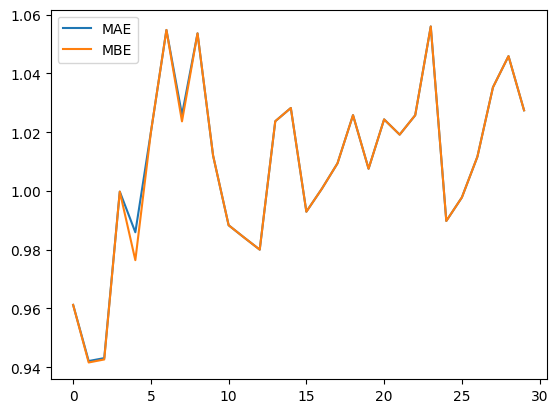

In [24]:
metrics[['MAE', 'MBE']].plot()

# Create external perfect forecast dataset to use as future covariates

In [25]:
from enfobench.dataset.utils import create_perfect_forecasts_from_covariates

perfect_forecasts = create_perfect_forecasts_from_covariates(
    past_covariates,
    horizon=pd.Timedelta("7 days"),
    step=pd.Timedelta("12 hour"),
)

In [26]:
perfect_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275856 entries, 0 to 275855
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        275856 non-null  datetime64[ns]
 1   cutoff_date      275856 non-null  datetime64[ns]
 2   temperature      275856 non-null  float32       
 3   dew_point        275856 non-null  float32       
 4   pressure         275856 non-null  float32       
 5   wind_speed       275856 non-null  float32       
 6   wind_gust        275856 non-null  float32       
 7   wind_bearing     275856 non-null  float32       
 8   precipitation    275856 non-null  float32       
 9   snow             275856 non-null  float32       
 10  cloud_cover      275856 non-null  float32       
 11  solar_radiation  275856 non-null  float32       
dtypes: datetime64[ns](2), float32(10)
memory usage: 14.7 MB


In [27]:
perfect_forecasts.head()

,timestamp,cutoff_date,temperature,dew_point,pressure,wind_speed,wind_gust,wind_bearing,precipitation,snow,cloud_cover,solar_radiation
0,2011-11-23 12:00:00,2011-11-23 11:00:00,8.515167,6.053314,1018.570374,3.163105,7.092710,227.930420,-2.328306e-07,0.0,1.0,247.303711
1,2011-11-23 13:00:00,2011-11-23 11:00:00,9.366150,6.898102,1018.497498,3.694861,7.186031,235.672974,-2.328306e-07,0.0,1.0,219.641495
2,2011-11-23 14:00:00,2011-11-23 11:00:00,9.818268,7.336670,1018.578125,3.870760,6.684762,234.186523,-2.328306e-07,0.0,1.0,151.042435
3,2011-11-23 15:00:00,2011-11-23 11:00:00,9.655426,7.545349,1018.738159,3.420094,5.839092,232.220032,-2.328306e-07,0.0,1.0,68.137222
4,2011-11-23 16:00:00,2011-11-23 11:00:00,9.179779,7.419464,1018.985535,3.134620,5.201840,221.905396,-2.328306e-07,0.0,1.0,15.961771


In [28]:
perfect_forecasts.tail()

,timestamp,cutoff_date,temperature,dew_point,pressure,wind_speed,wind_gust,wind_bearing,precipitation,snow,cloud_cover,solar_radiation
275851,2014-02-27 19:00:00,2014-02-20 23:00:00,5.689819,1.813721,997.900513,3.469654,6.335038,234.681274,0.0,2.910383e-08,0.187646,0.0
275852,2014-02-27 20:00:00,2014-02-20 23:00:00,4.810242,2.094910,997.599365,3.247617,5.910464,234.341431,0.0,2.910383e-08,0.198816,0.0
275853,2014-02-27 21:00:00,2014-02-20 23:00:00,3.816071,2.081482,997.349792,2.962546,5.246741,227.134399,0.0,2.910383e-08,0.053958,0.0
275854,2014-02-27 22:00:00,2014-02-20 23:00:00,3.409973,1.926727,996.695862,2.885335,4.526915,207.307251,0.0,2.910383e-08,0.091282,0.0
275855,2014-02-27 23:00:00,2014-02-20 23:00:00,2.926239,1.651093,995.616455,3.008154,5.425984,196.426453,0.0,2.910383e-08,0.096165,0.0


In [29]:
full_dataset = Dataset(
    target=target.loc["2012-01-01":"2013-12-31"],
    past_covariates=past_covariates,
    future_covariates=perfect_forecasts,
)

In [30]:
crossval_df = cross_validate(
    ExampleModel(200), 
    full_dataset,
    start_date=pd.Timestamp("2013-01-01T00:00:00"),
    end_date=pd.Timestamp("2013-02-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|██████████| 30/30 [00:01<00:00, 16.21it/s]


Merge the target values with the forecasts

Evaluate the metrics you are interested in.

In [31]:
evaluate_metrics(
    crossval_df, 
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

,MAE,MBE,weight
0,200.008643,200.008643,1.0


In [33]:
metrics = evaluate_metrics(
    crossval_df, 
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    },
    groupby="cutoff_date"
)
metrics

100%|██████████| 30/30 [00:00<00:00, 85.31it/s]


,cutoff_date,MAE,MBE,weight
0,2013-01-01,199.961201,199.961201,1.0
1,2013-01-02,199.941597,199.941597,1.0
2,2013-01-03,199.942621,199.942621,1.0
3,2013-01-04,199.999754,199.999754,1.0
4,2013-01-05,199.976416,199.976416,1.0
5,2013-01-06,200.019952,200.019952,1.0
6,2013-01-07,200.054776,200.054776,1.0
7,2013-01-08,200.023660,200.023660,1.0
8,2013-01-09,200.053617,200.053617,1.0
9,2013-01-10,200.012036,200.012036,1.0


<Axes: >

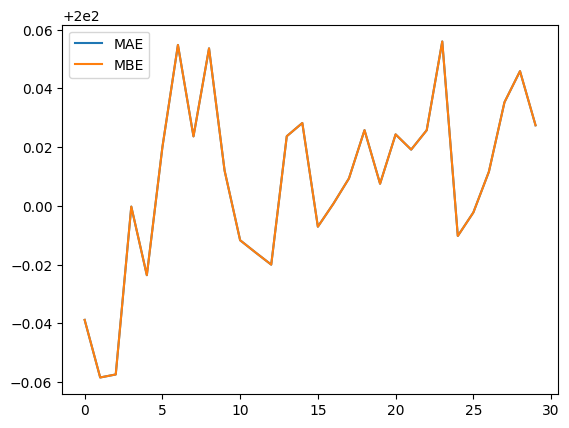

In [34]:
metrics[['MAE', 'MBE']].plot()